<a href="https://colab.research.google.com/github/atenchen/220-lab4/blob/master/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author Information
Name: \<Alvin Chen\>

B-Number: \<B00760047\>

Email: \<achen172@binghamton.edu\>

## General Instructions 
### Due October 7th, 11:59 PM.

In the following assignment, you will be implementing functions and their analytical derivatives to train linear classifiers and neural networks on the MNIST dataset. 

Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section. 

The experiments section for each classifier also need to be implemented. You should follow the instructions above the cell. You may also add additional cells. 

Cells marked **run** need to be run to set up the appropriate infrastructure, but do not need to be modified. Make sure you have run the previous cells before running the current cell, or you may get an error.

Submission will be via GitHub Classroom. **You are required to have at least 10 commits for this assignment.**


## Import statements

**Run** the cell to import the packages needed for the code below. You may other packages but ask first. 

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Backpropagation


### Linear Transformation

Linear transformations are vector-valued functions that take D-dimensional  vectors $x \in \mathbb{R}^{D}$ and transform them into M-dimensional vectors, $y \in \mathbb{R}^{M}$. We are going to use linear transformation with ["bias trick"](https://en.wikipedia.org/wiki/Affine_transformation#Augmented_matrix) to implement the transformation:

$$
y = xW + b
$$


In this assignment, you will use this transformation in the SVM, softmax, and neural network classifiers.

You will need to implement both the forward and backward direction of this linear layer. Take a look here for more details on the [backpropagation of a linear layer.](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html)

**Implement** linear_forward(X, W) that returns linear transformations on data X using the augmented parameter matrix, W. 

In [25]:
def linear_forward(x, w):
    """
    Computes the forward pass for a linear transformation.

    The input x has shape (N, D) and contains a minibatch of N
    samples, where each sample x[i] has shape (D). We will 
    transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, D)
    - w: A numpy array of weights, of shape (D+1, M)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w)

    The returned (x, w) is redundant, but makes the constructing the entire layer
    a little more concise.

    """

    out = None # Initialize the out variable.

    #
    # PUT YOUR CODE BELOW: Below, implement the linear forward pass. Store the result in out.
    # Make sure to do the bias trick! 
    x_prime = np.copy(x)
    w_prime = np.copy(w)
    N,D = np.shape(x_prime)
    x_prime = np.append(x_prime, np.ones((N,1)), axis = 1)
    x_prime[N-1,D] = 1
    out = x_prime.dot(w)


    # The lines below do not need to be changed.
    cache = (x, w)
    
    return out, cache

**Implement** linear_backward(dout, cache) that returns the analytical gradients with respect to X and W.

In [24]:
def linear_backward(d_upstream, cache):
    """
    Computes the backward pass for an linear layer.

    Inputs:
    - d_upstream: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, D)
      - w: Weights, of shape (D+1, M)

    Returns a tuple of:
    - dx: Gradient of the output of this layer with respect to x, of shape (N, D).
          This is the downstream gradient.
    - dw: Gradient with respect to w, of shape (D+1, M)
    """
    x, w = cache
    dx, dw = None, None

    # PUT YOUR CODE BELOW: Implement the linear backward pass by calculating the
    # gradient with respect to the cached inputs x and w. Store them in the 
    # variables dx and dw.
    N, D = np.shape(x)
    M = np.shape(w)[1]
    dx = d_upstream.dot(w[:D,:].transpose())
    bias = [np.sum(d_upstream, axis = 0)]
    dw = np.append(x.transpose().dot(d_upstream),bias,axis = 0)


   
 
    # The lines below do not need to be changed.

    return dx, dw

Finite difference is the discrete analog of derivatives, used to implement gradients numerically. While analytical derivates are faster to compute, they tend to be difficult to implement and error prone. It is standard practice to perform a gradient check by comparing the analytical gradient implementation with a numerical gradient. 

The multi-variate central difference for a function $f(x,y)$ is given by:
$$
\frac{\partial  f}{\partial x} = \frac{f(x-h, y)-f(x+h, y)}{2h}
$$
and 
$$
\frac{\partial  f}{\partial y} = \frac{f(x, y-h)-f(x, y+h)}{2h}
$$

The pattern holds for functions with higher number of variables. For central finite difference, generally $h=10^{-6}$. 

The multi-variate chain can be written as: 

$$
\frac{\partial L}{\partial x_i} = \sum^{m}_{\mathcal{l}=1} \frac{\partial L}{\partial y_l}\frac{\partial y_l}{\partial x_i}
$$

This simplifies nicely as the gradient for each variable in the matrix the sum of the products of the upstream gradient. `d_upstream` and the finite difference matrix. 


**Implement**  the `finite_difference_linear` function the next cell to test your implementation of the linear_forward and linear_backward functions. 

In [26]:
def finite_difference_linear(d_upstream, cache):
    '''
    Computes the numerical gradient for a linear layer

    Inputs:
    - d_upstream: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, D)
      - w: Weights, of shape (D+1, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, D).  This is the downstream
          gradient.
    - dw: Gradient with respect to w, of shape (D+1, M)
    '''


    # PUT YOUR CODE BELOW: Implement the finite difference for the linear
    # function.  Return the gradient at input (x,w) w.r.t to x and w.
    x,w = cache
    N,D = np.shape(x)
    M = np.shape(w)[1]
    dx = np.zeros((N,D))
    dw = np.zeros((D+1, M))
    for row in range(N):
      for column in range(D):
        h = 10**(-6) 
        h_prime = np.zeros((N,D))
        h_prime[row,column] = 10**(-6)
        x_positive = x + h_prime
        x_negative = x - h_prime
        df_numerator = linear_forward(x_positive,w)[0] - linear_forward(x_negative,w)[0]
        df = df_numerator/(2 * h)
        for i in range(N):
          for j in range(M):
            dx[row,column] += df[i,j] * d_upstream[i,j]
    for row in range(D+1):
      for column in range(M):
        h = 10**(-6) 
        h_prime = np.zeros((D+1,M))
        h_prime[row,column] = 10**(-6)
        w_positive = w + h_prime
        w_negative = w - h_prime 
        df_numerator = linear_forward(x, w_positive)[0] - linear_forward(x,w_negative)[0]
        df = df_numerator/(2 * h)
        for i in range(N):
          for j in range(M):
            dw[row,column] += df[i,j] * d_upstream[i,j]

    
    
    
    # The lines below do not need to be changed.
    return dx, dw

**Run** this cell to do a gradient check to test the analytical gradients from the `linear_backward` function with `finite_difference_linear`.  

In [27]:
def gradient_check_linear():
    N = 16
    D = 4
    C = 3

    test_weight = np.random.random((D+1, C))
    test_input = np.random.random((N, D))
    dout = np.random.random((N, C))

    cache = (test_input, test_weight)
    
    grad_x_numerical, grad_w_numerical = finite_difference_linear(dout, cache)
    grad_x_analytical, grad_w_analytical = linear_backward(dout, cache)
    check_input_gradient = np.allclose(grad_x_numerical, grad_x_analytical)
    check_weight_gradient = np.allclose(grad_w_numerical, grad_w_analytical)

    if not check_input_gradient:
        print("The gradient with respect to x failed")

    if not check_weight_gradient:
        print("The gradient respect to w failed")
    
    print("gradient check for linear passed!")

gradient_check_linear()

gradient check for linear passed!


## Part 2: Linear Classifiers


### MNIST Dataset

MNIST is a dataset images of handwritten digits compiled by the National Institute of Standards and Technology (NIST). The dataset is widely used as a testing ground for machine learning algorithms for image classification.  

The images are 28x28 pixels with only a single grayscale channel. You will be using 20,000 samples from the original training dataset for our next set of experiments. 

You will perform tests on the 10,000 sample test set.

In this section, we will implement the linear classifiers with the MNIST dataset

**Run** the following cell to define some helper functions to load the MNIST data.

In [28]:
def mnist_data_parser_helper(csv_file_name):
    X = []
    Y = []
    with open(csv_file_name,'r') as _file:
        csv_reader = csv.reader(_file, delimiter=",")
        for row in csv_reader:
            Y.append(float(row[0]))
            X.append([float(i) for i in row[1:]])
    return (np.array(X), np.array(Y))

def get_mnist_train_data():
    X_train, Y_train = mnist_data_parser_helper("sample_data/mnist_train_small.csv")
    return X_train, Y_train

def get_mnist_test_data():
    X_test, Y_test = mnist_data_parser_helper("sample_data/mnist_test.csv")
    return X_test, Y_test

**Run** the following cell to visualize some of the samples from the MNIST dataset.

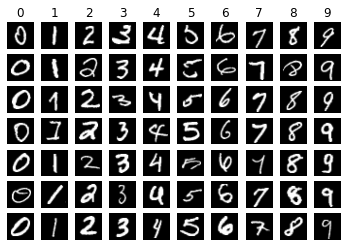

In [29]:
x_train, y_train = get_mnist_train_data()

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = list(range(10))

num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train.astype('uint8') == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8').reshape(28,28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

**Run** the following cell to gather the training dataset.


In [30]:
x_train, y_train = get_mnist_train_data()  # Get the training dataset

**Run** the following gather the testing dataset. 

In [31]:
x_test, y_test = get_mnist_test_data()     # Get the test dataset

**Run** the following normalize the input dataset to have a mean of 0 and standard deviation of 1. 

In [32]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = (x_train - x_mean)/(x_std)
x_test = (x_test - x_mean)/(x_std)

**Run** the following cell to check the dimensions of the data.

In [33]:
N, dim = x_train.shape
N_test, _ = x_test.shape
print(f"Number of training sample {N} with {dim} pixels per image")
print(f"Number of training sample {N_test} with {dim} pixels per image")

Number of training sample 20000 with 784 pixels per image
Number of training sample 10000 with 784 pixels per image


#### Implement and Evaluate ML Models

In this problem we are optimizing parametric ML models on high-dimensional real world data. As we've seen before in our optimization tasks, even simple polynomial functions can have many local minima that our optimizers can get stuck on.


Therefore, we need to be able to evaluate how well our model was optimized on the data, especially on the with different hyperparameters. Hyperparameters are parameters that control the learning process that are not updated during the training process, such learning rate or model size.


For large enough datasets, a common strategy is to use [validation sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) to evaluate the [best model](https://en.wikipedia.org/wiki/Model_selection). In the next cell, split the training dataset into training and validation set with an 80-20 split ratio. 

**Implement** the following cell to split the `x_train` and `y_train` arrays to training and validations sets with an 80-20 split ratio. Place the split arrays in to the `DATA` dictionary. This dictionary will be used to feed data into the `Solver`.

In [37]:
# Perform training and validation dataset splits

# PUT YOUR CODE BELOW
DATA = {"X_train": x_train[:16000],      # Replace with the value here
        "X_val" : x_train[16000:],       # Replace with the value here
        "Y_train" : y_train[:16000],     # Replace with the value here
        "Y_val" : y_train[16000:]}       # Replace with the value here


#### Optimizing Algorithm

**Run** the following cell to define the stochastic gradient descent algorithm that we will use to optimize our models. 

In [38]:
def sgd(w, dw, lr=1e-2):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """

    w -= lr * dw
    return w

#### Model Solver


The following solver class optimizes a given model using mini-batch gradient optimizations. 

**Run** the following cell to define the `Solver` class. 

In [39]:
class Solver(object):
    """
    Solver class for the learnable models using 
    mini-batch gradient descent.
    """

    def __init__(self,
                 model,
                 data,
                 learning_rate=1e-3,
                 num_epochs=50,
                 batch_size=200,
                 validation_frequency=16):
        """
        Construct a new Solver instance.

        Inputs:
          model: Python class equiped with forward, backward, predict methods and a params dictionary
          data: Dictionary with X_train, X_val,  Y_train, Y_val keys
          learning_rate: Float, step size of the optimizer
          num_epochs: Int, Number of times to completely traverse X_train
          batch_size: Int, The number of samples in update
          validation_frequency: Int, Solver performs validation loop every validation_frequency batches.
                               Set this to a high number if num_epochs is large
        """
        self.model = model
        
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.validation_frequency = validation_frequency

        self.num_training = data["X_train"].shape[0]
        self.input_dim = data["X_train"].shape[1]
        
        intervals = list(range(0, self.num_training, batch_size))[1:]
        
        self.X_train = np.array_split(data["X_train"], intervals, axis=0)
        self.y_train = np.array_split(data["Y_train"], intervals)

        self.num_batches_in_training = len(self.X_train)

        self.X_val = data["X_val"]
        self.y_val = data["Y_val"]

        self.update_rule = sgd
        self.loss_history = []
        self.validation_history = []

        self.iteration_num = 0


    def _step(self, batch_id):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        X_batch = self.X_train[batch_id]
        y_batch = self.y_train[batch_id]

        # Compute loss and gradient
        score, cache = self.model.forward(X_batch)
        loss, dL = self.model.loss(score, y_batch)
        _, grads = self.model.backward(dL, cache)

        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            next_w = self.update_rule(w, dw, self.learning_rate)
            self.model.params[p] = next_w
    
    
    def train(self):
        """
        Optimization to train the model

        """

        for epoch in range(self.num_epochs):
            for batch_id in range(self.num_batches_in_training):
                
                self._step(batch_id)

                self.iteration_num += 1

                if (self.iteration_num % self.validation_frequency == 0):
                    self.validate()

        self.validate()


    def validate(self):
        """
        Checks the validation error of the model at the time it is being called.

        """

        N = self.y_val.shape[0]
        predictions = self.model.predict(self.X_val)
 
        accuracy = np.count_nonzero(predictions == self.y_val.astype(int))

        print(f"The validation accuracy at iteration {self.iteration_num}  is \
              {(float(accuracy)/N)*100}%")

### (a) Linear Classifier

We will be using two linear classifiers on the (MNIST) dataset. Using the linear transform you’ve implemented before, you will use SGD to train a multiclass support vector machine (SVM) and softmax classifiers to predict the handwritten digits.

The linear classifier base class implements training and prediction methods shared by the linear classifiers. 

**Implement** the following cell to complete the definition of the following `LinearClassifier` class.

Implement the `__init__`, `forward`, `backward`, and `predict` methods. 

Complete the following:
- The `__init__()` method initializes the class. You must generate a random weight matrix of shape `(input_dim+1,num_classes)`  
- The `forward()` method generates the scores for given an input sample, by applying a `linear_forward()` transformation on the inputs `x` and weights matrix `self.params['W1']`
- The `backward()` method returns the gradients with respect to the inputs and weights, using the `linear_backward()` method. Make sure the key for the returned dictionary `weights_gradient` matches the paramts dictionary.
- The `predict()` method returns the labels predicted from the scores returned using the `self.forward()` method. 

In [ ]:
class LinearClassifier(object):
    """
    The base class for the linear classifier. 

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self,
                 input_dim=784,
                 num_classes=10):
        self.params = {}
        self.input_features = input_dim
        self.num_classes = 10

        # PUT YOUR CODE BELOW:                                                    
        # Initialize the weights of the linear classifier. Weights should be      
        # initialized from a Gaussian centered at 0.0 with standard deviation     
        # equal to 1e-3, and biases should be initialized to zero.                   
        # Store in the self.W dictionary with key name 'W1'                       
                                                                                 
        # The lines below do not need to be changed in the method
        

    def forward(self, x):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - x: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = x.shape
        num_classes = self.num_classes
        out = None
        cache = None
        
        # PUT YOUR CODE BELOW:                                                    
        # Implement this method. Generate the scores in out and store the old      
        # values into the cache.                                                  
            
        # The lines below do not need to be changed
         
    
        return out, (cache, )

    def backward(self, dout, cache):
        weight_gradients = {}
        dx = None
        
        # PUT YOUR CODE BELOW:                                                                   
        # Implement this method. Generate the gradients with respect to x from 
        # cache and set it dx, the upstream error signal.
        # Store the gradient with respect to the weights in the weights_gradients
        # dictionary. Make sure the key matches the ket of the params dictionary    

        # The lines below do not need to be changed 

        return (dx, weight_gradients)

    def predict(self, x):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - x: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(x.shape[0])
        
        # PUT YOUR CODE BELOW:                                                                   
        # Implement this method. Store the predicted labels in y_pred.            


        # The lines below do not need to be changed

        return y_pred
    

    def loss(self, scores, y_batch):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - scores: A numpy array of shape (N, C) containing a minibatch of N
          data points; each point has dimension C, where C is the number of classes.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to scores; an array of the same shape as scores
        """
        # The lines below do not need to be changed
        # Do not implement anything here. The subclasses will override this method
        pass

### (b) Support Vector Machine


The LinearSVM class defines an SVM-based linear classifier. The classifier uses the hinge loss to optimize the model parameters. 

The Hinge loss for an input sample $x_i$ (a vector) is given by: 

$$
L_i = \sum_{j \neq y_i} \text{max}(0, s_j-s_{y_i}+1)
$$


Where, $y_i$ is the label of the $i$-th sample.  The label is the correct class label where $0 \leq y_i \lt C$, where C is the number of classes.   The scalar $s_{y_i}$ is the $y_i$-th element of the score vector. 

The average loss over N samples is therefore:

$$
L = \frac{1}{N}\sum^{N}_{i=1}L_i
$$

The per-sample gradient of the loss w.r.t. the score $s_j$ is given by:

$$
\frac{\partial  L_i}{\partial s_j} = \left \{
\begin{array}{ll}
0 & j = s_{y_i} \text{ or } s_j-s_{y_i}+1 \leq 0    \\
1 & j \neq s_{y_i} \text{ and } s_j-s_{y_i}+1 > 0 \\
\end{array}
\right.
$$

**Implement** the `svm_loss` function in the following cell. Store the average loss the `loss` variable and the gradient w.r.t `scores` in the `dy` variable. This is the loss over multiple samples, therefore you should take the mean of the loss. 


In [ ]:
def svm_loss(scores, y_batch):
    """
    Returns hinge loss of the scores and y_batch. 

    Inputs:
    - scores: A numpy array of shape (N, C) containing a minibatch of N
      data points; each point has dimension C, where C is the number of classes.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to scores; an array of the same shape as scores
    """
    loss = 0
    dy = np.zeros(scores.shape)  
    # PUT YOUR CODE BELOW:                                                       
    # Implement the structured SVM loss, storing the  
    # result in loss. Make sure to take the mean of the loss.
    # Hint: The intermediate results maybe useful for the gradient calculation                                                        
    
  
    # PUT YOUR CODE BELOW:                                                                    
    # Implement the gradient for the SVM loss, storing the result    
    # in dy.                                                                    
    #                                                                           
    # Hint: Instead of computing the gradient from scratch, it may be easier    
    # to reuse some of the intermediate values that you used to compute the     
    # loss.                                                                     


    # The lines below do not need to be changed.
    return loss, dy

**Run** the following cell to define the `LinearSVM` class with your implementation of the `svm_loss`

In [ ]:
class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, scores, y_batch):
        return svm_loss(scores, y_batch)

#### SVM Experiments

In the next few cells run the `Solver` with SVM models on the training and validation data you've defined previously. Use the `DATA` dictionary you defined previously as the data parameter.

As you have seen with previous assignments, optimizations can be highly dependent on the hyperparameters of the model. You should try multiple models with different learning rates. You may also increase the amount of time you train by increasing the number of epochs. 

Keep the top-5 best performing models and the worst performing model on the validation set.


**Implement** hyperparameter validation loop in the next cell to train multiple models with different hyperparameters. Keep the top-5 best performing models on the validation set. You can try different learning rates. You may change the num_epochs, but be wary of timeouts. 

**Implement** the testing performance of your top-5 performing models on the test set and print the results. 

**Implement** the next cell to visualize the weights corresponding to each sample in the *best* performing SVM models. You should have ten 28x28 images.

Make sure to rescale the  weights to be between 0 and 255.

Depending on your learning rate and weights, it might not look so great. If all the images look the same but you have good accuracy, try subtracting the average of weights from weights of each class. 

You can add additional cells below.

### (c) Cross-Entropy Loss

The Softmax class defines the cross-entropy loss for training and prediction methods like the previous the linear classifiers.
The cross-entropy loss is actually the composition of two distinct functions: the softmax function and the cross-entropy.
However,
we commonly refer to it just as the cross-entropy loss,
with the implicit understanding that for deep learning,
the cross-entropy is not computed on the raw scores,
but rather the softmax of the raw scores.

For a score vector $s$, the softmax activation of the $j$-th element is given by,

$$
\sigma_j = \frac{e^{s_{j}}}{\sum^{C - 1}_{k=0}e^{s_k}}
$$

A simple implementation of the softmax function can be numerically unstable. Large scores can result in an overflow. Large scores are normalized to be not too big or too small. [Check here for more details.](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/#:~:text=Computing%20softmax%20and%20numerical%20stability)


The cross-entropy is a measure of the difference between two probability distributions.
In the general case,
the cross-entropy $H$ between the true probability distribution $P$ and the estimated probability distribution $Q$ is given by:

$$
H(P, Q)=-\sum_{x \in \mathcal{X}} P(x) \log Q(x)
$$

where $\mathcal{X}$ is the event space.
It is a measure of how "far off" our estimated distribution $Q$ is from $P$.
(Note that because $P$ and $Q$ are actually functions,
$H$ in this case is a function operating on functions, also known as an *operator*.)

In our case,
$P$ is zero except for the correct label,
and thus the cross-entropy reduces to simply the negative logarithm of the score corresponding to the correct class,
which is just

$$
L_i = -\log(\sigma_{y_i}))
$$

where $y_i$ is the correct label of the $x_i$ input sample,
and $\sigma_{y_i}$ is the softmax output of the corresponding correct label. $L$ is then just the average over the $L_i$.

The derivative of the softmax is given by, 

$$
\frac{\partial\sigma_i}{\partial s_j} = \left \{
\begin{array}{ll}
\sigma_i(1 - \sigma_{j}) & i = j     \\
-\sigma_i\sigma_j & i \neq j  \\
\end{array}
\right.
$$

Details on the derivation can be found [here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/).

The derivative of the negative logarithm is given by, 

$$
\frac{\partial (-\log)}{\partial \sigma_{y_i}} = -\frac{1}{\sigma_{y_i}}
$$

**Implement** the `cross_entropy_loss` function in the following cell. The function returns a tuple of `(loss, dy)` where, `loss` is the cross-entropy loss based on the inputs, and `dy` is the gradient of the loss with respect to the `scores` input.This is the loss over multiple samples, therefor you should take the mean of the loss. 

In [ ]:
def cross_entropy_loss(scores, y_batch):
    """
    Computes the cross-entropy layer

    Inputs:
    - scores: A numpy array containing the scores, of shape (N, C)
    - y_batch: A numpy array containing the labels, of shape (N, 1)

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to scores; an array of the same shape as scores
    """

    loss = 0
    dy = np.zeros(scores.shape)

    # PUT YOUR CODE BELOW:                                                       
    # Implement the cross-entropy loss, storing the  
    # result in loss. Make sure to take the mean of the loss.
    # Hint: The intermediate results maybe useful for the gradient calculation  



    # PUT YOUR CODE BELOW:                                                                    
    # Implement the gradient for the cross-entropy loss, storing the result    
    # in dy.                                                                    
    #                                                                          
    # Hint: Instead of computing the gradient from scratch, it may be easier    
    # to reuse some of the intermediate values that you used to compute the     
    # loss. 

    # The lines below do not need to be changed.
    return loss, dy

**Run** the following cell to define the `Softmax` classifier class.

In [ ]:
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, scores, y_batch):
        return cross_entropy_loss(scores, y_batch)

#### Softmax Experiments

In the next few cells run the `Solver` with Softmax models on the training and validation data you've defined previously, similar to the SVM experiements.  Use the `DATA` dictionary you defined previously as the data parameter.


Keep the top-5 best performing models and the worst performing model on the validation set.

**Implement** hyperparameter validation loop in the next cell to train multiple models with different hyperparameters. Keep the top-5 best performing models on the validation set. You can try different learning rates. You may change the num_epochs, but be wary of timeouts. 

**Implement** the next cell to visualize the weights corresponding to each sample in the *best* performing Softmax models. You should have ten 28x28 images.


You can add additional cells below.

Depending on your learning rate and weights, it might not look so great. If all the images look the same but you have good accuracy, try subtracting the average of weights from weights of each class. 

**Implement** the testing performance of your top-5 performing Softmax models on the test set and print the results. 

## Part 3: Deeper Neural Networks (Very Slightly)
 


Up until now, we have been working with linear classification models. Linear classification models are very adept at modelling data that have nice linear boundaries. In practice, realy world data is rarely linear. Multilayer fully-connected neural networks with non-linear activation functions on the other hand can model non-linear data-label relationships. 

Such models are a powerful extension to linear models and are the building blocks of modern deep learning. 

In this section, you will be implementing a two-layer fully-connected neural network. Fully-connected neural networks perform the transformation that you've implemented above coupled with a non-linear activation function. You will also implement your own version of the rectified linear unit fuction (commonly reffered to as ReLU), a non-linear activation function.

#### (a) ReLU Function

The ReLU function is given by:

$$
f(x) = x^{+} = max(0, x)
$$

**Implement** the following cell to complete the definition of the `ReLU_forward` function.

In [ ]:
def ReLU_forward(x):
    """
    Computes the forward pass for a ReLU actiivation.

    The input x has shape (N, D) and contains a minibatch of N
    examples, where each example x[i] has shape (D). We will 
    transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, D)


    Returns a tuple of:
    - out: output, of shape (N, D)
    - cache: (x)
    """
    out = None
    
    # PUT YOUR CODE BELOW: Implement the ReLU forward pass. Store the result in 
    # out. You will need to reshape the input into rows.

    
    # The lines below do not need to be changed.

    cache = (x,)
    return out, cache

The ReLU derivative is given by: 

$$
\frac{\partial f(x)}{\partial x} = \left\{
\begin{array}{ll}
      0 & x \leq 0 \\
      1 & x > 0 \\
\end{array}
\right. 
$$

Where, $f(x)$ is the ReLU function of course.


**Implement** the following cell to complete the definition of the `ReLU_backward` function.

In [ ]:
def ReLU_backward(d_upstream, cache):
    """
    Computes the backward pass for an linear layer.

    Inputs:
    - d_upstream: Upstream derivative, of shape (N, D)
    - cache: Tuple of:
      - x: Input data, of shape (N, D)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, D)
    """
    x,  = cache
    dx = None

    # PUT YOUR CODE BELOW: Implement the ReLU backward pass.                                 

    # The lines below do not need to be changed.

    return (dx, )

#### (b) Two-layer Neural Network

**Implement** the definition of the two-layer neural network below.

Similar to the `LinearClassifier` class, you should write the `__init__`, `forward`, `backward`, and `predict` methods. We will be using the cross-entropy loss for this network. 

Complete the following:
- The `__init__()` method initializes the class. You must generate two random weight matrices. We will be using the bias trick, so the bias should concatenated to the weight matrix. They are initialized differently. 

- The `forward()` method generates the scores for given an input sample, by applying a `linear_forward()` and `ReLU_forward()` with appropriate inputs. Make sure to store and return the cache for the intermediate steps. 

- The `backward()` method returns the gradients with respect to the inputs and weights, using the `linear_backward()` and `ReLU_backward()`. Make sure the keys for the returned dictionary `weights_gradient` matches the keys in the `self.params` dictionary.

- The `predict()` method returns the labels predicted from the scores returned using the `self.forward()` method.


In [ ]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be transform - relu - transform - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """
    def __init__(self,
                 input_dim,
                 hidden_dim=100,
                 num_classes=10,
                 weight_scale=1e-3):
        """
        """

        self.params = {}
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.num_classes = num_classes

        # PUT YOUR CODE BELOW: Initialize the weights of the two-layer net. Weights should be     
        # initialized from a Gaussian centered at 0.0 with standard deviation      
        # equal to weight_scale, and biases should be initialized to zero.         
        # All weights should be stored in the dictionary self.params, with first   
        # layer weights and using the keys 'W1' and second layer weights and using 
        # the keys 'W2'. Make sure to concatenate the weights and biases to make a 
        # a single matrix for the bias trick!                                                            


        # The lines below do not need to be changed in this method.

    
    def forward(self, x):
        """
        Implement the forward pass of the neural network and return the scores

        Inputs:
        - x: A numpy array containing input data, of shape (N, self.input_dim)
        

        Returns a tuple of:
        - out: output, of shape (N, D)
        - Tuple of tuples:
          - cache_lin_1: A tuple (x, w1) 
            - x: data, of shape (N, self.input_dim)
            - w1: Weight of linear layer 1 of shape (self.input_dim+1, self.hidden_dim)
          - cache_relu_1: A tuple (h, )
            - h : data, of shape (N, self.hidden_dim)
          - cache_lin_2:  A tuple (h, w2)
            - h: data, of shape (N, self.hidden_dim)
            - w2: weight of linear 2 of shape (self.hidden_dim+1, C)
        """
        out = None
        N, feature_dim = x.shape
        cache_lin_1, cache_relu_1, cache_lin_2 = None, None, None

        if (feature_dim != self.input_dim):
            raise Exception(f"The input feature dimension of {feature_dim} does \
                            not match the expected feature dimension of \
                            {self.input_dim} ")

        
        # PUT YOUR CODE BELOW: Perform a forward pass of the two-layer net.
        # The architecture is transform - relu - transform 
        # Make to store the appropriate cache in the appropriate variables                     


        # The lines below do not need to be changed in this method.

        return out, (cache_lin_1, cache_relu_1, cache_lin_2)


    def backward(self, dout, cache):
        """
        Implement the backward pass of the neural network and return the
        gradients w.r.t the input, and the weights

        Inputs:
        - dout: Upstream derivative, of shape (N, C)
        - cache: Tuple of tuples:
          - cache_lin_1: A tuple (x, w1) 
            - x: data, of shape (N, self.input_dim)
            - w1: Weight of linear layer 1 of shape (self.input_dim+1, self.hidden_dim)
          - cache_relu_1: A tuple (h, )
            - h : data, of shape (N, self.hidden_dim)
          - cache_lin_2:  A tuple (h, w2)
            - h: data, of shape (N, self.hidden_dim)
            - w2: weight of linear 2 of shape (self.hidden_dim+1, C)

        Returns a tuple of:
          - dx: A numpy array of the gradient with respect to x, of shape (N, D)
          - weight_gradients: A dictionary of numpy arrays containing the
              gradients with respect to the weights. 
        """

        weight_gradients = {}
        dx = None

        N, classes = dout.shape
        
        cache_lin_1, cache_relu_1, cache_lin_2 = cache

        if (classes != self.num_classes):
            raise Exception(f"The output class dimension of {classes} does \
                            not match the expected number of classes \
                            {self.num_classes} ")

        # PUT YOUR CODE BELOW: Perform a backward pass of the two-layer net.                      


        # The lines below do not need to be changed in this method.
        return (dx, weight_gradients)
    
    def predict(self, x):

        """
        Implement the predictions from the forward pass of the neural network and 
        returns it. 

        Inputs:
        - x: Input data, of shape (N, self.input_dim)
        
        Returns a tuple of:
          - predictions: A numpy array of shape (N, ) of the predicted class per sample 
          
        """

        y_pred = None

        
        # PUT YOUR CODE BELOW: Predict the classes of using the two-layer net.                    


        # The lines below do not need to be changed in this method.

        return y_pred

    def loss(self, scores, y_batch):
        """
        """
        # The lines below do not need to be changed in this method.
        return cross_entropy_loss(scores, y_batch)

### (c) Experiments

Similar to the linear classifiers, you also want to identify the best configuration of hyperparameters that perform the best for your dataset. Similar to the case of the linear models, you can vary the learning rate for your solver. You should use the `Solver` class for these models as well. Use the `DATA` dictionary you defined previously as the data parameter.

Additionaly, the neural network provides another hyperparameter to vary, the the number of neurons in the hidden layer. 

Adding a large of number of neurons may cause a large degradation in performance, the linear transformation scales as $O(N^3)$ with the number of neurons. 




**Implement** a hyperparameter validation loop in the next cell to train multiple models with different hyperparameters. Keep the top-5 best performing models on the validation set. You may change learning rate, and hidden dims. You may change the num_epochs, but be wary of timeouts. 

**Implement** the testing performance of your top-5 performing NN models on the test set and print the results. You can add additional cells below.

**Implement** visualization for the `W1` weights of the *best* performing NN models. There are `hidden_dim` many of them per model. You should visualize a subset of the weights. You can select the columns at random. 

You can add additional cells below.